# COMP5318 - Machine Learning and Data Mining: Assignment 1
<div style="text-align: right"> Due: Wednesday 14 Oct 2020 11:59PM </div>

The goal of this assignment is to build a classifier to classify some grayscale images of the size 28x28 into a set of categories. The dimension of the original data is large, so you need to be smart on which method you gonna use and perhaps perform a pre-processing step to reduce the amount of computation. Part of your marks will be a function of the performance of your classifier on the test set.

# Load Libraries

In [7]:
import h5py
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from scipy import stats
from bisect import bisect
from scipy.spatial import distance
from scipy.stats import multivariate_normal as mvn
from math import exp, sqrt, pi
print(os.listdir("./Input/train"))
print(os.listdir("./Input/test"))
# train_files = [name for name in os.listdir("./Input/train") if not name.endswith('DS_Store')]
# test_files = [name for name in os.listdir("./Input/test") if not name.endswith('DS_Store')]
# print(train_files)
# print(test_files)

['images_training.h5', 'labels_training.h5']
['.DS_Store', 'images_testing.h5', 'labels_testing_2000.h5']


# Load Data

In [8]:
with h5py.File('./Input/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('./Input/train/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])

# using H['datatest'], H['labeltest'] for test dataset.
print(data_train.shape,label_train.shape)

(30000, 784) (30000,)


In [9]:
with h5py.File('./Input/test/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])
with h5py.File('./Input/test/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])

# using H['datatest'], H['labeltest'] for test dataset.
print(data_test.shape,label_test.shape)

(5000, 784) (2000,)


# Principal Component Analysis


<div style="text-align: right"> Sourced: https://stats.stackexchange.com/questions/125172/pca-on-train-and-test-datasets-should-i-run-one-pca-on-traintest-or-two-separa </div>
<div style="text-align: right"> https://towardsdatascience.com/pca-with-numpy-58917c1d0391 </div>
<div style="text-align: right"> https://stackoverflow.com/questions/10818718/principal-component-analysis </div>



## Computing the Eigenvectors and Eigenvalues


In [10]:
data = data_train
data = data - np.mean(data, axis=0)
print(data.shape)
covariance_matrix = np.cov(data.T)
#print(covariance_matrix)
eig_val, eig_vec = np.linalg.eig(covariance_matrix)
print("First 20 Eigenvalues: \n", eig_val[:20], "\n")

(30000, 784)
First 20 Eigenvalues: 
 [19.8611004  12.10997382  4.1078177   3.3719857   2.61461635  2.35693788
  1.61184549  1.28149922  0.92593176  0.89463432  0.67365696  0.62224642
  0.52434522  0.44943814  0.41495554  0.4023021   0.37964251  0.36276613
  0.31522305  0.31177036] 



## Picking Principal Components


In [11]:
variance_explained = []
for i in eig_val:
    variance_explained.append((i/sum(eig_val))*100)     
print("First 10 Variance Explained: \n", variance_explained[:10], "\n") 

cumulative_variance_explained = np.cumsum(variance_explained)
print("First 10 Cummulative Variance Explained: \n", cumulative_variance_explained[:10], "\n") 

First 10 Variance Explained: 
 [29.077053310731294, 17.72924699012503, 6.013928330120427, 4.936655363514209, 3.8278512994969107, 3.4506048031981504, 2.3597744497586266, 1.876140819639972, 1.3555828542550032, 1.309762764368793] 

First 10 Cummulative Variance Explained: 
 [29.07705331 46.8063003  52.82022863 57.75688399 61.58473529 65.0353401
 67.39511455 69.27125537 70.62683822 71.93660099] 



### Plot Cumulative explained variance to find elbow point

187


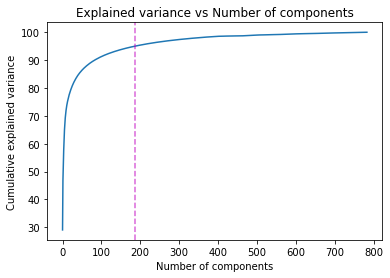

In [12]:
comp = bisect(cumulative_variance_explained, 95) #Number of components at 95% explained variance
sns.lineplot(x = np.arange(data.shape[1]), y=cumulative_variance_explained)
plt.axvline(comp, c='m', linestyle='--', alpha=0.6)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Explained variance vs Number of components")
print(comp)

## Project Data Onto Lower-Dimensional Linear Subspace

### Project onto training data

In [13]:
n_component = comp
projection_matrix = (eig_vec.T[:][:n_component]).T
X_train_pca = data.dot(projection_matrix)

print(X_train_pca.shape)

(30000, 187)


### Project on to test data

In [14]:
data = data_test
data = data - np.mean(data, axis=0)
X_test_pca = data.dot(projection_matrix)

print(X_test_pca.shape)

(5000, 187)


# Split Data
Split training data into train and validaiton sets on 70:30

In [15]:
train_pct_index = int(0.7 * X_train_pca.shape[0])
print(train_pct_index)
X_train, X_val = X_train_pca[:train_pct_index], X_train_pca[train_pct_index:]
y_train, y_val = label_train[:train_pct_index], label_train[train_pct_index:]
# print(np.sum(X_train_pca[:train_pct_index] == X_train)/len(X_train_pca[:train_pct_index]))
# print(X_train[1])
# print(X_test_pca[1])
print(np.all(X_train[:10] == X_train_pca[:10]))
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

21000
True
(21000, 187)
(9000, 187)
(21000,)
(9000,)


# Gaussian Naive Bayes Classifier

In [16]:
def get_label_stats(X, y):
    labels = set(y)
    label_stats = dict()
    for label in labels:
        x_labels = X[y == label]
        feature_stats = []
        for i in range(X.shape[1]):
            feature_x = x_labels[:,i]
            feature_stats.append([np.mean(feature_x), np.var(feature_x)])
        label_stats[label] = feature_stats
    return label_stats

In [17]:
def get_prior(X, y):
    labels = set(y)
    prior = dict()
    for label in labels:
        prior[label] = float(len(y[y == label])) / len(y)
    return prior

In [18]:
def get_p_given_c(Xq, mean, var):
    return  exp( -((Xq-mean)**2 / (2 * var )) ) / (sqrt(2 * pi * var))

In [19]:
def get_posterior(label_stats, row, prior, labels):
    prob = dict()
    for label in labels:
        # prob[label] = prior[label]
        likelihood = 1
        for i in range(row.shape[0]):
            mean, var = label_stats[label][i][0], label_stats[label][i][1]
            likelihood *= get_p_given_c(row[i], mean, var)
        prob[label] = prior[label] * likelihood
    return prob

In [20]:
def get_predictions(posterior):
    predictions = []
    for row in posterior:
        predictions.append(max(row, key=row.get))
    return predictions

In [21]:
def NB_Classifier(X_train, y_train, X_test):
    label_stats = get_label_stats(X_train, y_train)
    prior = get_prior(X_train, y_train)
    posteriors = []
    for X_q in X_test:
        posteriors.append(get_posterior(label_stats, X_q, prior, label_set))
    y_pred = get_predictions(posteriors)
    return y_pred

In [29]:
label_set = set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

# Train Model

In [30]:
y_pred = NB_Classifier(X_train, y_train, X_val)

# Training Confusion Matrix

In [31]:
y_actu = pd.Series(y_val, name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print(df_confusion)
# acc = get_accuracy(pred, y_train)
# print(acc)
print("\nAccuracy:", np.mean(y_pred == y_actu))

Predicted    0    1    2    3    4    5    6    7    8    9
Actual                                                     
0          668    4   21   75    3   13   59    1   91    2
1            6  762    8   51    2    5    9    0   26    0
2           16    0  572   11  110    8   76    1   73    1
3           25   29   11  711   24    6   28    1   59    0
4            2    1   79   35  627    3   95    0   70    0
5            8    0   11    0    1  679   53  174   20    5
6          124    2   81   24   73   14  447    0  118    0
7            0    0    0    0    0   89    8  814    4   38
8           18    0   10    8   10   19   31   22  765    2
9            0    0    1    0    0   10   16   72   14  735

Accuracy: 0.7533333333333333


# Calculate Test Dataset
<div style="text-align: right"> Sourced: COMP5318 Tutorial 5 - Classification I </div>


In [32]:
X_train = X_train_pca
y_train = label_train
X_test = X_test_pca[:label_test.shape[0]]
y_test = label_test

label_stats = get_label_stats(X_train, y_train)
prior = get_prior(X_train, y_train)
posteriors = []
for X_q in X_test:
    posteriors.append(get_posterior(label_stats, X_q, prior, label_set))
y_pred = get_predictions(posteriors)

In [33]:
y_pred = NB_Classifier(X_train, y_train, X_test)

# Test Confusion Matrix

In [34]:
y_actu = pd.Series(y_test, name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print(df_confusion)
# acc = get_accuracy(pred, y_train)
# print(acc)
print("\nAccuracy:", np.mean(y_pred == y_actu))

Predicted    0    1    2    3    4    5    6    7    8    9
Actual                                                     
0          127    2    3   13    2    3   18    0   24    0
1            0  165    1    8    0    1    2    0    7    0
2            3    0  125    1   23    0   38    0   16    0
3           13    2    1  159    6    3    9    0   14    0
4            1    1   21   10  137    0   29    0   21    0
5            0    0    2    0    0  129    5   45    9    0
6           20    0   14   13   13    2  101    0   27    0
7            0    0    0    0    0   21    0  160    0   11
8            7    0    4    1    1    7   12    8  186    1
9            0    0    0    0    0    5    4   10    7  166

Accuracy: 0.7275
